In [1]:
import numpy as np
import pandas as pd

### Barchart Chart of the Day Out of Sample Testing
**Barchart is a data provider for market news, stock quotes, and many other financial information.** In this project, we test Barchart's Chart of the Day feature with out of sample data and see how their "alpha" decays over time. Note that Chart of the Day is a newsletter style feature that is being offered daily to subscribers for free, with potential short to medium term investment opportunities. 

**A typical Chart of the Day article looks like this.** (source: https://www.barchart.com/story/news/17589238/chart-of-the-day-protagonist-therapeutics-wide-opinions) As a subscriber, you will get a one-pager like this on every trading day, suggesting a stock picked by Barchart's analysts. Note that a typical sentence at the end of first paragraph of each article always goes like this: "Since the Trend Seeker signaled a buy on xx date the stock gained yy %", and it is generally a sizable return. Since we don't have premium access to know exactly how their signals work (or at least I have not found a simple way to decode their Trend Seeker signals), I thought it might be interesting to see how these stocks are performing once they are mentioned in Barchart's Chart of the Day feature.

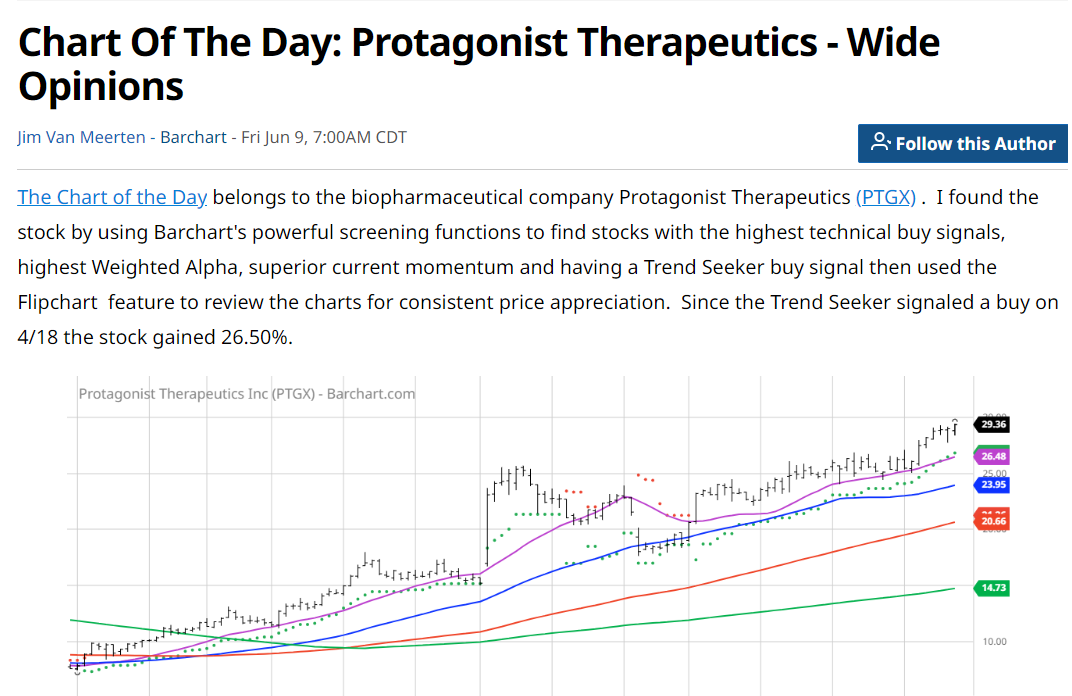

In [6]:
from IPython import display
display.Image('Barchart Picture.png',width=600,height=300)

**Chart of the Day feature seems to have started the daily posts since Nov 22nd, 2022.** This should give us enough sample size to evaluate the post-mortem performance, given its almost 8 months history. Note that in this exercise, we define $t_0^{i}$ as the date that stock $i$ was mentioned in Chart of the Day post, and $P_0^{i}$ as the closing price of stock $i$ at the end of $t_0^{i}$. The reason that we did not choose opening price at $t_0^{i}$ is to avoid look ahead bias, in the cases where Barchart's daily post was published after market open. 